# REPORTING: Explanatory visuals.
***
This notebook build on the work in the `Exploration` notebook, but focusses soley on generating the correct graphs for the report in `Lyft_Bay_Wheels.pdf`.

The notebook follows the slides in the report, creating first individual plots and then combined visuals per slide, latter being stored in the images folder.

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.ticker import MultipleLocator
import matplotlib.gridspec as gridspec
%matplotlib inline

import seaborn as sns

from qbstyles import mpl_style
mpl_style(dark=False)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from bay_wheels_trips.src.feature_engineering import temporal_features
from bay_wheels_trips.src.stats_summary import durationStatsByGroup, weekGrowthBreakdown

## 0. Setup
***
Prepare data & plot settings

#### 0.1 Load data

In [15]:
df = pd.read_hdf('bay_wheels_trips/data/202001-tripdata-cleaned-locs.h5')
print(df.shape)

# add temporal features
df = temporal_features(df)
df.info()

(295836, 20)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 295836 entries, 0 to 295852
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             295836 non-null  int64         
 1   start_time               295836 non-null  datetime64[ns]
 2   end_time                 295836 non-null  datetime64[ns]
 3   start_station_id         295836 non-null  int64         
 4   start_station_name       146850 non-null  object        
 5   start_station_latitude   295836 non-null  float64       
 6   start_station_longitude  295836 non-null  float64       
 7   end_station_id           295836 non-null  int64         
 8   end_station_name         146502 non-null  object        
 9   end_station_latitude     295836 non-null  float64       
 10  end_station_longitude    295836 non-null  float64       
 11  bike_id                  295836 non-null  int64         
 12  use

#### 0.2 get subsets

In [16]:
# duration
duration_subset = df[df['duration_min']<30]
duration_pcts = np.percentile(duration_subset['duration_min'], [25,50,75])

# week
week_subset = df[(df['week']>1) & (df['day_type'] == 'weekday')]

# distance
distance_subset = df[(df['distance_km'] < 10) & (df['distance_km'] > 0.2)]
distance_pcts = np.percentile(distance_subset['distance_km'], [25,50,75])

# distance + duration
reg_subset = df[(df['duration_min']<60) & (df['distance_km']>0.2)]

#### 0.3 set palette
We use our own palette:
* red, dark-grey, light-grey for comparison of 3 variables
* red, mid-grey for comparison of 2 variables
* red for univariate

In [20]:
set_colors = {'red': '#bf4040',
              'dark_grey': '#404040',
              'mid_grey' : '#807f80',
              'light_grey':'#bfbfbf'}

In [21]:
sns.set_palette(['#bf4040','#404040','#bfbfbf'])

In [22]:
#convert cm to inches for the final output
def cm2inch(value):
    return value/2.54

#### 0.4 set output

In [31]:
path = 'bay_wheels_trips/images/'

## Slide 1: trips over time
***

#### 1.1 trips per day (of month)

In [23]:
p1 = df.groupby(['day','week','day_type']).size().reset_index()
p1.columns = ['day','week','day_type', 'cnt']
p1.head()

,day,week,day_type,cnt
0,1,1,weekday,3138
1,2,1,weekday,6184
2,3,1,weekday,6462
3,4,1,weekend,4397
4,5,1,weekend,4257


In [24]:
def plot_1_1(ax, p1, text_font = 12, tick_font = 12, label_font = 14, title_font = 15, legend_font = 12, legend_anchor = ((0.14,0.783))):
    # add shading based on the week
    x_offset = 0.5 # barplot; start is 0.5 before 'number'
    patch_alpha = 0.2
    ax.axvspan(0-x_offset, 5 - x_offset, color = 'grey', alpha = patch_alpha)
    ax.axvspan(12-x_offset, 19 - x_offset, color = 'grey', alpha = patch_alpha)
    ax.axvspan(26-x_offset, 31 - x_offset, color = 'grey', alpha = patch_alpha)

    # add text (week-nr)
    ax.text(2, 17000, 'week 1', fontsize=text_font, horizontalalignment='center', verticalalignment='center')
    ax.text(8, 17000, 'week 2', fontsize=text_font, horizontalalignment='center', verticalalignment='center')
    ax.text(15, 17000, 'week 3', fontsize=text_font, horizontalalignment='center', verticalalignment='center')
    ax.text(22, 17000, 'week 4', fontsize=text_font, horizontalalignment='center', verticalalignment='center')
    ax.text(28, 17000, 'week 5', fontsize=text_font, horizontalalignment='center', verticalalignment='center')

    # set colors
    colors = [set_colors['mid_grey'] if day == 'weekday' else set_colors['red'] for day in p1.day_type]
    g = sns.barplot(ax = ax, data = p1, x = 'day', y = 'cnt', palette = colors, dodge=False)

    # format y-axis to thousand-format
    g.set_yticklabels(['{:,.0f}'.format(v) for v in g.get_yticks()], size = tick_font)
    g.set_xticklabels([v+1 if v%2==0 else "" for v in g.get_xticks()], size = tick_font) # only odd
    ax.yaxis.set_minor_locator(MultipleLocator(500))
    ax.tick_params(axis='y', which = 'minor', direction = 'in')
    ax.set_ylim(0,18000)

    # labels
    ax.set_xlabel('day (of January 2020)', fontsize = label_font)
    ax.set_ylabel('trips', fontsize = label_font)
    ax.set_title('Bay Wheels trips per day', fontsize = title_font)

    # legend
    legend_elements = [Patch(facecolor = set_colors['mid_grey'], edgecolor=set_colors['mid_grey'], label = 'weekday'),
                       Patch(facecolor = set_colors['red'], edgecolor=set_colors['red'], label = 'weekend')]
    ax.legend(bbox_to_anchor=legend_anchor, handles=legend_elements, facecolor="white", edgecolor='white', framealpha=1, fontsize = legend_font)

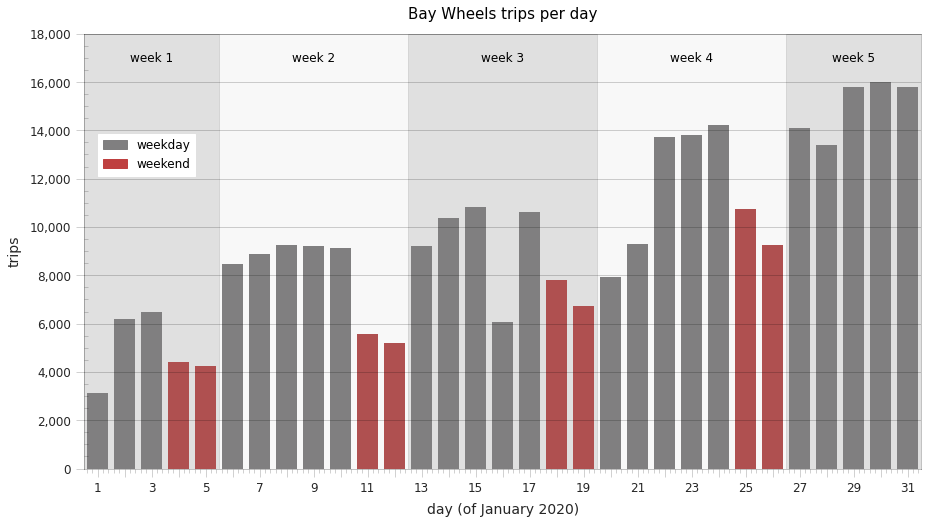

In [25]:
fig, ax = plt.subplots(figsize = (15,8))
plot_1_1(ax, p1)
plt.show()

#### 1.2 growth over week

In [27]:
#week-on-week growth
p2 = week_subset.groupby('week').size().reset_index()
p2.columns = ['week','cnt']

# scale to daily rides
p2['cnt'] = p2['cnt']/5
p2['growth'] = ((p2['cnt']/p2['cnt'].shift())-1)*100
p2

,week,cnt,growth
0,2,8986.6,NaN
1,3,9429.2,4.925111
2,4,11797.4,25.115598
3,5,15014.0,27.265330


In [28]:
def plot_1_2(ax, p2, text_font = 17, tick_font = 12, label_font = 14, title_font = 15):
    # make the plot
    g = sns.barplot(ax=ax, data = p2, x = 'week', y = 'cnt', color = set_colors['red'], dodge=False) #@, saturation = 0.5)

    # format y-axis to thousand-format
    g.set_yticklabels(['{:,.0f}'.format(v) for v in g.get_yticks()], size = tick_font)
    g.set_xticklabels(g.get_xticklabels(), size = tick_font)
    ax.yaxis.set_minor_locator(MultipleLocator(500))
    ax.tick_params(axis='y',which = 'minor', direction = 'in')
    ax.set_ylim(0,16000)

    # TODO: in text, add growth-rate above each bar or in the top of each bar
    ax.text(1, 8700, '+{:.1f}%'.format(p2[p2['week']==3].growth.iloc[0]), fontsize=text_font, color = 'white', horizontalalignment='center', verticalalignment='center')
    ax.text(2, 11100, '+{:.1f}%'.format(p2[p2['week']==4].growth.iloc[0]), fontsize=text_font, color = 'white', horizontalalignment='center', verticalalignment='center')
    ax.text(3, 14400, '+{:.1f}%'.format(p2[p2['week']==5].growth.iloc[0]), fontsize=text_font, color = 'white', horizontalalignment='center', verticalalignment='center')



    # label and title
    ax.set_xlabel('week', fontsize = label_font)
    ax.set_ylabel('average trips per day', fontsize = label_font)
    ax.set_title('average Bay Wheels trips per week-day', fontsize = title_font)


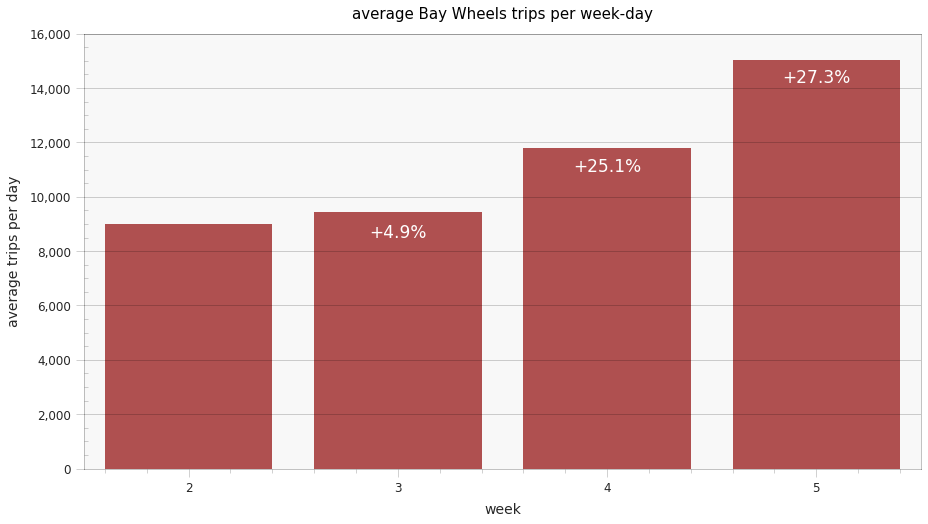

In [29]:
fig, ax = plt.subplots(figsize = (15,8))
plot_1_2(ax, p2)
plt.show()

#### 1.3 slide one output

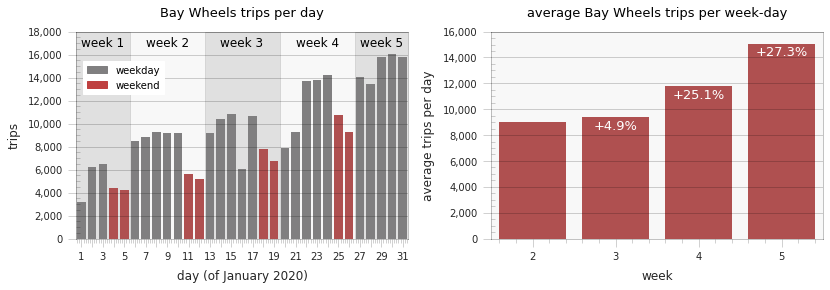

In [32]:
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(bottom=0.15, wspace=0.25) # ensure y-label plot two isn't overlapped

plot_1_1(ax[0], p1, text_font = 12, tick_font = 10, label_font = 12, title_font = 13, 
         legend_font = 10, legend_anchor = (0.28,0.88))

plot_1_2(ax[1], p2, text_font = 13, tick_font = 10, label_font = 12, title_font = 13)

# output
fig.set_size_inches([cm2inch(34),cm2inch(10)])
fig.savefig(path+'slide1.svg', dpi=300)

## Slide 2: Temporal variation trips
***

#### 2.1 trips per day

In [33]:
# we want to see a distribution of avg trips per day, to deal with varying number of days
# hence a pre-group over a countplot
r1 = df.groupby(['dow','day']).size().to_frame('cnt').reset_index()
r2 = r1[r1['cnt']>0].reset_index(drop=True)
r2.head()

,dow,day,cnt
0,monday,6,8482
1,monday,13,9216
2,monday,20,7913
3,monday,27,14077
4,tuesday,7,8871


In [34]:
def plot_2_1(ax, r2, text_font = 17, tick_font = 12, label_font = 14, title_font = 15):
    # main plot
    g = sns.barplot(ax=ax, data = r2, y = 'dow', x = 'cnt', estimator=np.mean,
                    color= set_colors['red'], capsize=0.1)

    # format y-axis to thousand-format
    ax.set_xticklabels(['{:,.0f}'.format(v) for v in np.arange(0,16000,2000)], size = tick_font) #hardcode
    g.set_yticklabels(g.get_yticklabels(), size = tick_font)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.tick_params(axis='x',which = 'minor', direction = 'in')
    ax.set_xlim(0,15000)
    
    # label and title
    ax.set_ylabel('day', fontsize = label_font)
    ax.set_xlabel('average trips per day', fontsize = label_font)
    ax.set_title('average Bay Wheels trips per day', fontsize = title_font)

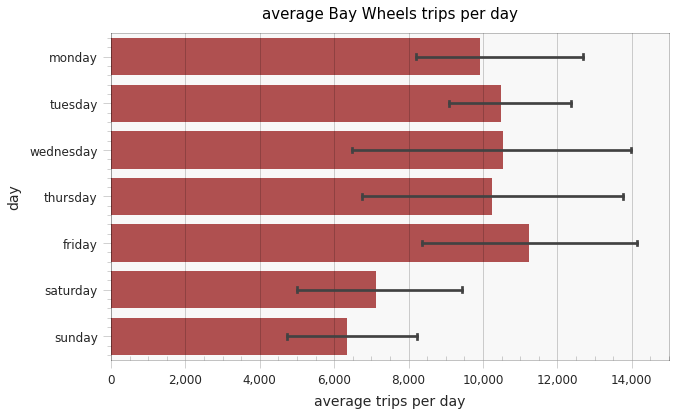

In [35]:
fig, ax = plt.subplots(figsize=(10,6))

plot_2_1(ax, r2, text_font = 17, tick_font = 12, label_font = 14, title_font = 15)

plt.show()

In [36]:
# do we need these error bars!?

#### 2.2 trips per hour

In [37]:
t1 = df.groupby(['day_type','hour','day']).size().to_frame('cnt').reset_index()

In [38]:
def plot_2_2(ax, t1, text_font = 17, tick_font = 12, label_font = 14, title_font = 15):
    # add shading based on the week
    x_offset = 0.5 # barplot; start is 0.5 before 'number'
    patch_alpha = 0.2
    ax.axvspan(7-x_offset, 10 - x_offset, color = 'grey', alpha = patch_alpha)
    ax.axvspan(16-x_offset, 19 - x_offset, color = 'grey', alpha = patch_alpha)

    
    
    # main plot
    g = sns.barplot(ax=ax, data = t1, x = 'hour', y = 'cnt', hue = 'day_type', estimator=np.mean,
                    palette = {'weekday': set_colors['red'], 'weekend': set_colors['mid_grey']}, ci=None)

    # format y-axis to thousand-format
    g.set_yticklabels(['{:,.0f}'.format(v) for v in g.get_yticks()], size = tick_font)
    #g.set_xticklabels(g.get_xticklabels(), size = tick_font)
    g.set_xticklabels([v+1 if v%2==0 else "" for v in g.get_xticks()], size = tick_font) # only odd
    ax.yaxis.set_minor_locator(MultipleLocator(500))
    ax.tick_params(axis='y',which = 'minor', direction = 'in')
    ax.set_ylim(0,1400)
    
    # label and title
    ax.set_xlabel('hour', fontsize = label_font)
    ax.set_ylabel('average trips per hour', fontsize = label_font)
    ax.set_title('average Bay Wheels trips per hour', fontsize = title_font)

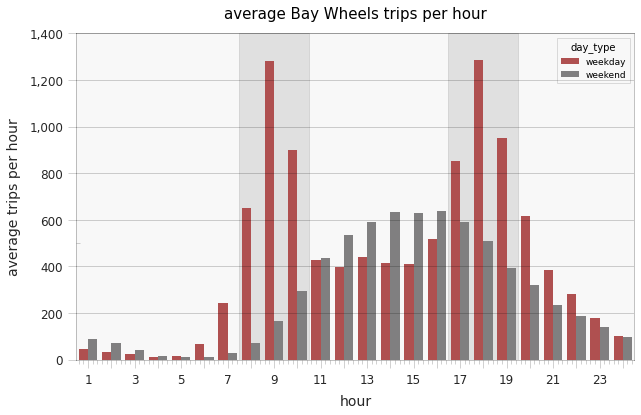

In [39]:
fig, ax = plt.subplots(figsize=(10,6))

plot_2_2(ax, t1, text_font = 17, tick_font = 12, label_font = 14, title_font = 15)

plt.show()

#### 2.3 slide 2 output

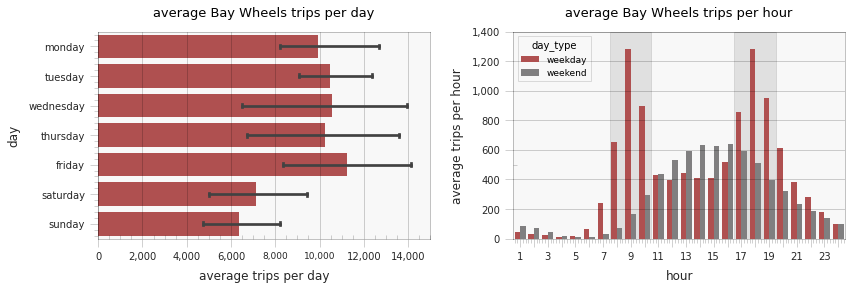

In [40]:
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(bottom=0.15, wspace=0.25) # ensure y-label plot two isn't overlapped

plot_2_1(ax[0], r2, text_font = 12, tick_font = 10, label_font = 12, title_font = 13)

plot_2_2(ax[1], t1, text_font = 12, tick_font = 10, label_font = 12, title_font = 13)

# output
fig.set_size_inches([cm2inch(34),cm2inch(10)])
fig.savefig(path+'slide2.svg', dpi=300)

#### 2.4 some additional stats

In [41]:
# weekend vs. weekdays
weekday_trips = r2[~r2['dow'].isin(['saturday','sunday'])]['cnt'].mean()
weekend_trips = r2[r2['dow'].isin(['saturday','sunday'])]['cnt'].mean()
weekday_trips/weekend_trips

1.5606886073989492

In [42]:
t1.head()

,day_type,hour,day,cnt
0,weekday,0,1,135
1,weekday,0,2,11
2,weekday,0,3,24
3,weekday,0,6,16
4,weekday,0,7,22


In [43]:
# rush hour weekday use vs. total weekday
t1[(t1['hour'].isin([8,9,10,17,18,19])) & (t1['day_type']=='weekday')]['cnt'].sum()/t1[t1['day_type']=='weekday']['cnt'].sum()

0.5187375992063492

In [44]:
# 'rush hour' weekend use vs. total weekend
t1[(t1['hour'].isin([8,9,10,17,18,19])) & (t1['day_type']=='weekend')]['cnt'].sum()/t1[t1['day_type']=='weekend']['cnt'].sum()

0.3149157949402775

## Slide 3: demographic breakdown
***

### slide 3a: metadata

#### 3.a.1 overall

In [65]:
def plot_3_a_1(ax, weekly_growth_subset, text_font = 17, tick_font = 12, label_font = 14, title_font = 15):
    # make the plot
    g = sns.countplot(ax = ax, data = weekly_growth_subset, x = 'week', color = set_colors['red'])
    
    # format y-axis to thousand-format
    ax.set_yticks(np.arange(0,100000,20000))
    ax.set_yticklabels(['{:,.0f}'.format(v) for v in np.arange(0,100000,20000)], size = tick_font) #hardcode
    g.set_xticklabels(g.get_xticklabels(), size = tick_font)
    ax.yaxis.set_minor_locator(MultipleLocator(5000))
    ax.tick_params(axis='y',which = 'minor', direction = 'in')

    # label and title
    ax.set_xlabel(' ', fontsize = label_font)
    ax.set_ylabel(' ', fontsize = label_font)
    ax.set_title('Total trips (Monday-Friday)', fontsize = title_font)


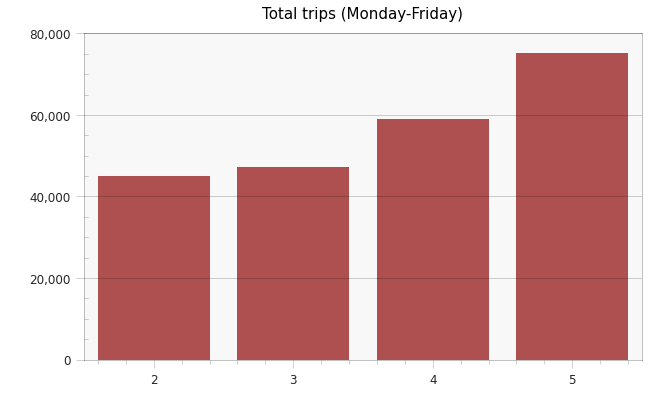

In [66]:
fig, ax = plt.subplots(figsize=(10,6))

plot_3_a_1(ax, week_subset, text_font = 17, tick_font = 12, label_font = 14, title_font = 15)

plt.show()

#### 3.a.2 user

In [67]:
def plot_3_a_2(ax, weekly_growth_subset, text_font = 17, tick_font = 12, label_font = 14, title_font = 15, legend_font = 12):
    # make the plot
    g = sns.countplot(ax=ax, data=weekly_growth_subset, x='week', hue='user_type',
                     palette = {'Subscriber': set_colors['red'], 'Customer': set_colors['mid_grey']})
    
     # format y-axis to thousand-format
    ax.set_yticks(np.arange(0,100000,20000))
    ax.set_yticklabels(['{:,.0f}'.format(v) for v in np.arange(0,100000,20000)], size = tick_font) #hardcode
    g.set_xticklabels(g.get_xticklabels(), size = tick_font)
    ax.yaxis.set_minor_locator(MultipleLocator(5000))
    ax.tick_params(axis='y',which = 'minor', direction = 'in')

    # label and title
    ax.set_xlabel(' ', fontsize = label_font)
    ax.set_ylabel(' ', fontsize = label_font)
    #ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
    #            mode="expand", borderaxespad=0, ncol=2, fontsize=legend_font)
    ax.legend().set_visible(False)

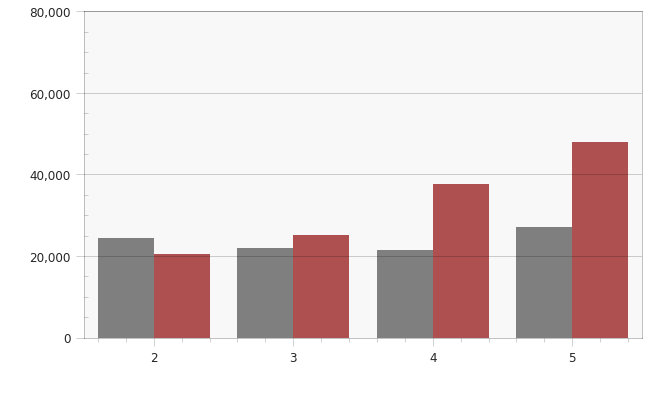

In [68]:
fig, ax = plt.subplots(figsize=(10,6))

plot_3_a_2(ax, week_subset, text_font = 17, tick_font = 12, label_font = 14, title_font = 15, legend_font = 12)

plt.show()

#### 3.a.3 rental access method

In [69]:
def plot_3_a_3(ax, weekly_growth_subset, text_font = 17, tick_font = 12, label_font = 14, title_font = 15, legend_font = 12):
    # make the plot
    g = sns.countplot(ax=ax, data=weekly_growth_subset, x='week', hue='rental_access_method', hue_order = ['app','undefined','clipper'])
    
     # format y-axis to thousand-format
    ax.set_yticks(np.arange(0,100000,20000))
    ax.set_yticklabels(['{:,.0f}'.format(v) for v in np.arange(0,100000,20000)], size = tick_font) #hardcode
    g.set_xticklabels(g.get_xticklabels(), size = tick_font)
    ax.yaxis.set_minor_locator(MultipleLocator(5000))
    ax.tick_params(axis='y',which = 'minor', direction = 'in')

    # label and title
    ax.set_xlabel(' ', fontsize = label_font)
    ax.set_ylabel(' ', fontsize = label_font)
    #ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
    #            mode="expand", borderaxespad=0, ncol=3, fontsize=legend_font)
    ax.legend().set_visible(False)

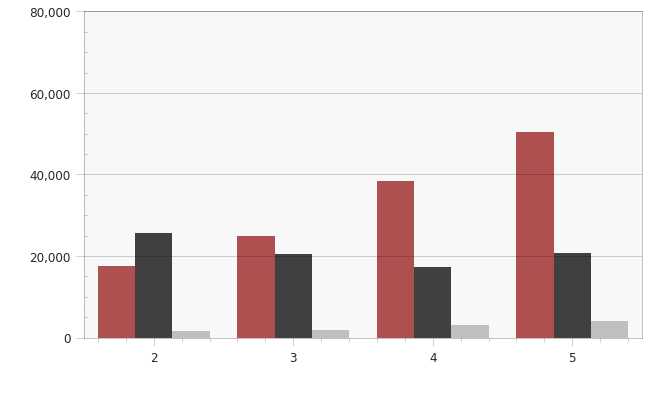

In [70]:
fig, ax = plt.subplots(figsize=(10,6))

plot_3_a_3(ax, week_subset, text_font = 17, tick_font = 12, label_font = 14, title_font = 15,legend_font = 12)

plt.show()

#### 3.a.4 location

In [71]:
def plot_3_a_4(ax, weekly_growth_subset, text_font = 17, tick_font = 12, label_font = 14, title_font = 15,legend_font = 12):
    # make the plot
    g = sns.countplot(ax=ax,data=weekly_growth_subset, x='week', hue='loc', hue_order = ['SF','BK','SJ'])
    
     # format y-axis to thousand-format
    ax.set_yticks(np.arange(0,100000,20000))
    ax.set_yticklabels(['{:,.0f}'.format(v) for v in np.arange(0,100000,20000)], size = tick_font) #hardcode
    g.set_xticklabels(g.get_xticklabels(), size = tick_font)
    ax.yaxis.set_minor_locator(MultipleLocator(5000))
    ax.tick_params(axis='y',which = 'minor', direction = 'in')

    # label and title
    ax.set_xlabel('week', fontsize = label_font)
    ax.set_ylabel(' ', fontsize = label_font)
    #ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
    #            mode="expand", borderaxespad=0, ncol=3, fontsize=legend_font)
    ax.legend().set_visible(False)

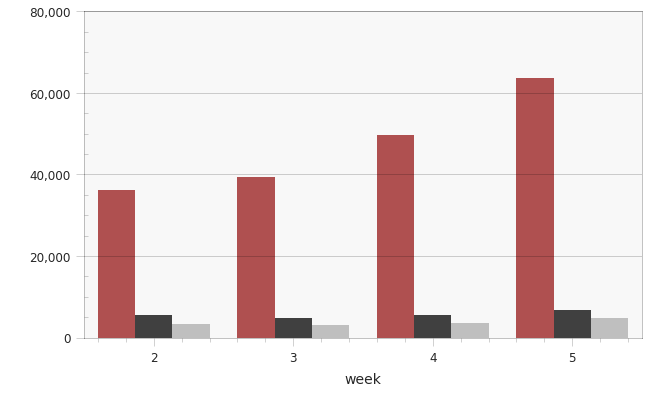

In [72]:
fig, ax = plt.subplots(figsize=(10,6))

plot_3_a_4(ax, week_subset, text_font = 17, tick_font = 12, label_font = 14, title_font = 15,legend_font = 12)

plt.show()

#### 3.a.5 combined

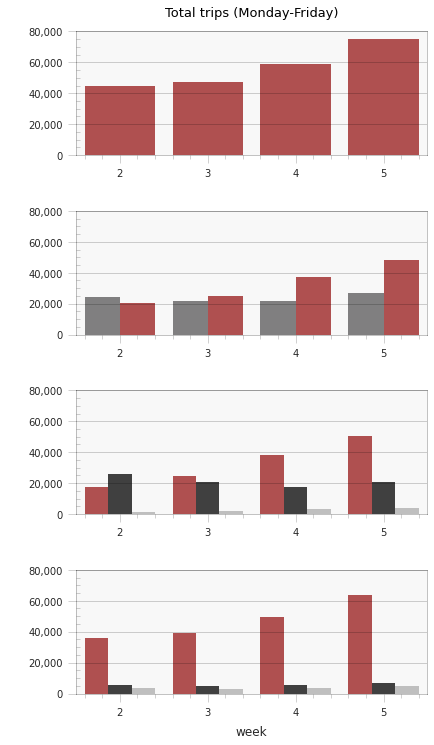

In [73]:
fig, ax = plt.subplots(4, 1)
plt.subplots_adjust(bottom=0.15, wspace=0.25, hspace=0.45) # ensure y-label plot two isn't overlapped

plot_3_a_1(ax[0], week_subset, text_font = 17, tick_font = 10, label_font = 12, title_font = 13)

plot_3_a_2(ax[1], week_subset, text_font = 17, tick_font = 10, label_font = 12, title_font = 15)

plot_3_a_3(ax[2], week_subset, text_font = 17, tick_font = 10, label_font = 12, title_font = 15)

plot_3_a_4(ax[3], week_subset, text_font = 17, tick_font = 10, label_font = 12, title_font = 15)


# output
fig.set_size_inches([cm2inch(16),cm2inch(32)])
fig.savefig(path+'slide3_1.svg', dpi=300)

### slide 3b: growth %
***

#### 3.b.1 overall growth

In [74]:
def plot_3_b_1(ax, p2, text_font = 17, tick_font = 12, label_font = 14, title_font = 15):
    # make the plot
    g = sns.barplot(ax=ax, data = p2[p2['week']>2], x = 'week', y = 'growth', color = set_colors['red'], dodge=False) #@, saturation = 0.5)
    ax.axhline(0,c='k')
    
    # format y-axis to thousand-format
    ax.set_yticks(np.arange(-20,80,20))
    ax.set_yticklabels(['{:,.0f}%'.format(v) for v in np.arange(-20,80,20)], size = tick_font) #hardcode
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.tick_params(axis='y',which = 'minor', direction = 'in')

    # label and title
    ax.set_xlabel(' ', fontsize = label_font)
    ax.set_ylabel(' ', fontsize = label_font)
    ax.set_title('Week-on-week trip growth', fontsize = title_font)


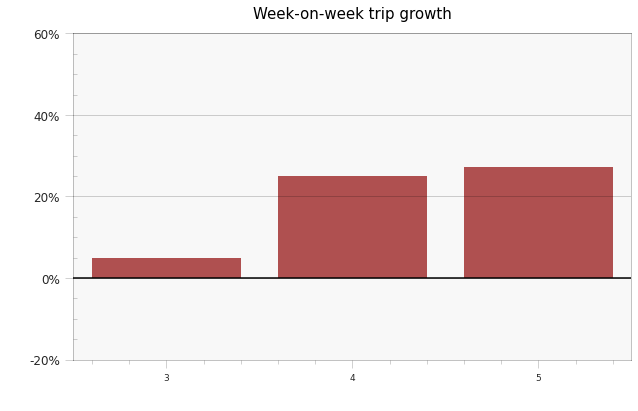

In [75]:
fig, ax = plt.subplots(figsize = (10,6))
plot_3_b_1(ax, p2)
plt.show()

#### 3.b.2 user-type

In [77]:
user_growth, user_total = weekGrowthBreakdown(week_subset, 'user_type', ['Subscriber', 'Customer'])
user_growth.head()

,week,user_type,cnt,growth
0,2,Subscriber,20514,NaN
1,2,Customer,24419,NaN
2,3,Subscriber,25274,23.203666
3,3,Customer,21872,-10.430403
4,4,Subscriber,37545,48.551871


In [78]:
def plot_3_b_2(ax, user_growth, hue_set, color_palette, text_font = 17, tick_font = 12, label_font = 14, title_font = 15, xlabel=False):
    # make the plot
    g = sns.barplot(ax=ax, data = user_growth[user_growth['week']>2], x = 'week', y = 'growth', hue=hue_set, 
                   palette = color_palette)
    ax.axhline(0,c='k')
    
    # format y-axis to thousand-format
    ax.set_yticks(np.arange(-20,80,20))
    ax.set_yticklabels(['{:,.0f}%'.format(v) for v in np.arange(-20,80,20)], size = tick_font) #hardcode
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.tick_params(axis='y',which = 'minor', direction = 'in')

    # label and title
    if xlabel:
        ax.set_xlabel('week', fontsize = label_font)
    else:
        ax.set_xlabel(' ', fontsize = label_font)
    ax.set_ylabel(' ', fontsize = label_font)
    ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

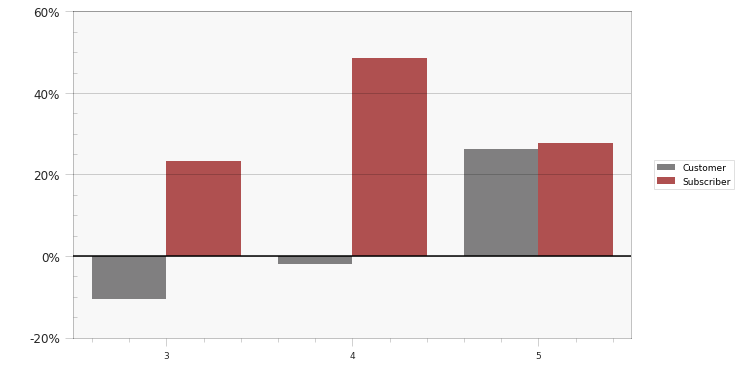

In [79]:
fig, ax = plt.subplots(figsize = (10,6))
color_palette = {'Subscriber': set_colors['red'], 'Customer': set_colors['mid_grey']}
plot_3_b_2(ax, user_growth, 'user_type', color_palette, text_font = 17, tick_font = 12, label_font = 14, title_font = 15)
plt.show()

#### 3.b.3 rentall access method

In [80]:
rental_growth, rental_total = weekGrowthBreakdown(week_subset, 'rental_access_method', ['app','clipper','undefined'])
rental_growth.head()

,week,rental_access_method,cnt,growth
0,2,app,17668,NaN
1,2,clipper,1634,NaN
2,2,undefined,25631,NaN
3,3,app,24795,40.338465
4,3,clipper,1833,12.178703


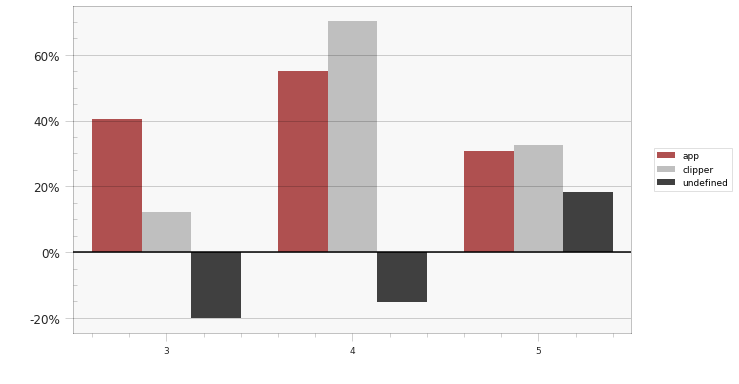

In [81]:
fig, ax = plt.subplots(figsize = (10,6))
color_palette = {'app': set_colors['red'], 'undefined': set_colors['dark_grey'], 'clipper': set_colors['light_grey']}
plot_3_b_2(ax, rental_growth, 'rental_access_method', color_palette, text_font = 17, tick_font = 12, label_font = 14, title_font = 15)
plt.show()

#### 3.b.4 location

In [82]:
loc_growth, loc_total = weekGrowthBreakdown(week_subset, 'loc', ['SF','BK','SJ'])
loc_growth.head()

,week,loc,cnt,growth
0,2,SF,36100,NaN
1,2,BK,5419,NaN
2,2,SJ,3414,NaN
3,3,SF,39263,8.761773
4,3,BK,4815,-11.145968


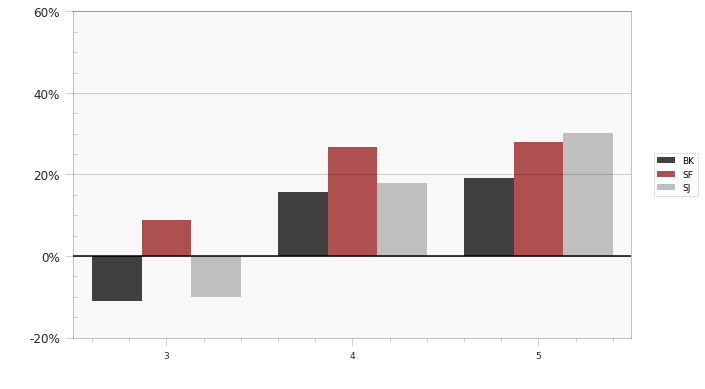

In [83]:
fig, ax = plt.subplots(figsize = (10,6))
color_palette = {'SF': set_colors['red'], 'BK': set_colors['dark_grey'], 'SJ': set_colors['light_grey']}
plot_3_b_2(ax, loc_growth, 'loc', color_palette, text_font = 17, tick_font = 12, label_font = 14, title_font = 15)
plt.show()

#### 3.b.5 combined

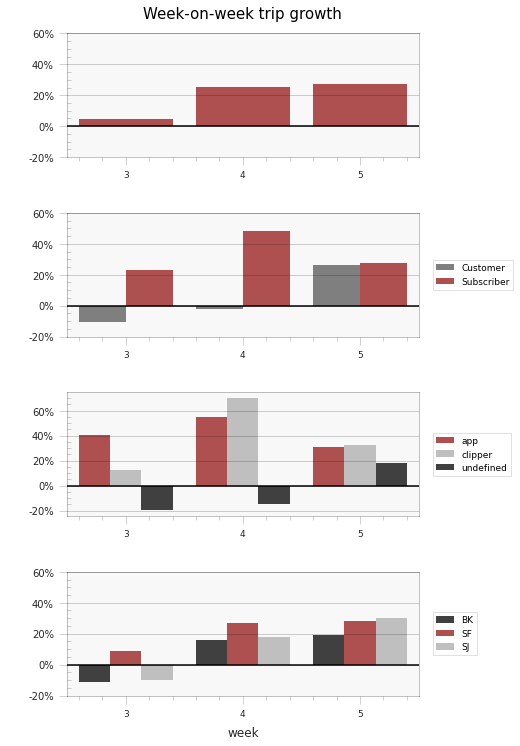

In [85]:
fig, ax = plt.subplots(4, 1)
plt.subplots_adjust(bottom=0.15, wspace=0.25, hspace=0.45) # ensure y-label plot two isn't overlapped

plot_3_b_1(ax[0], p2, text_font = 17, tick_font = 10, label_font = 12, title_font = 15)

color_palette = {'Subscriber': set_colors['red'], 'Customer': set_colors['mid_grey']}
plot_3_b_2(ax[1], user_growth, 'user_type', color_palette, text_font = 17, tick_font = 10, label_font = 12, title_font = 15)

color_palette = {'app': set_colors['red'], 'undefined': set_colors['dark_grey'], 'clipper': set_colors['light_grey']}
plot_3_b_2(ax[2], rental_growth, 'rental_access_method', color_palette, text_font = 17, tick_font = 10, label_font = 12, title_font = 15)

color_palette = {'SF': set_colors['red'], 'BK': set_colors['dark_grey'], 'SJ': set_colors['light_grey']}
plot_3_b_2(ax[3], loc_growth, 'loc', color_palette, text_font = 17, tick_font = 10, label_font = 12, title_font = 15, xlabel=True)

# output
fig.set_size_inches([cm2inch(16),cm2inch(32)])
fig.savefig(path+'slide3_2.svg', dpi=300)

### 3.c combine the full set
***

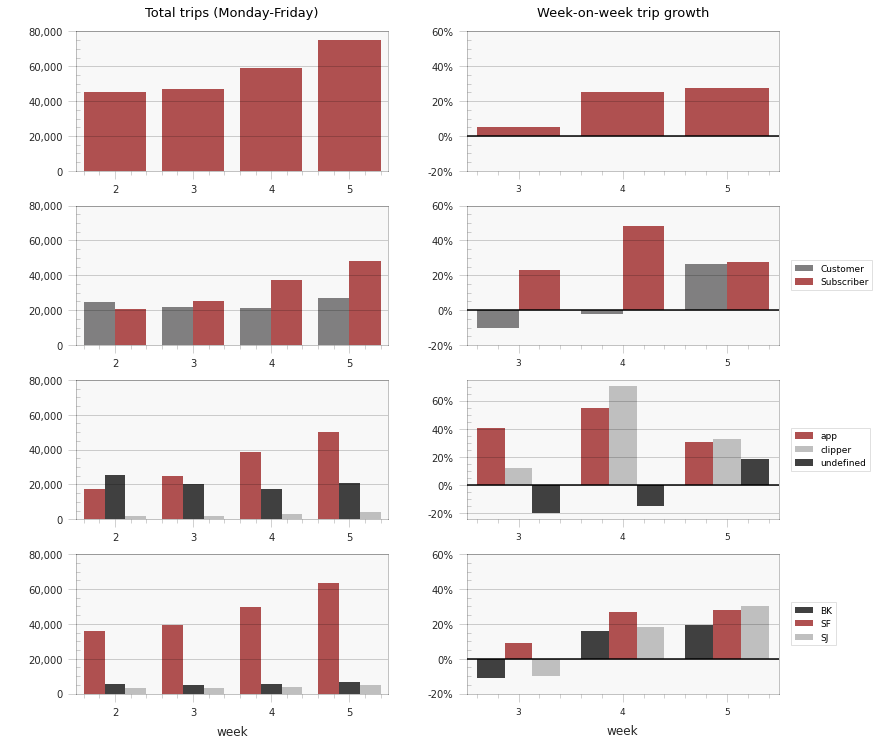

In [86]:
fig, ax = plt.subplots(4, 2)
plt.subplots_adjust(bottom=0.15, wspace=0.25, hspace=0.25) # ensure y-label plot two isn't overlapped

#### left
plot_3_a_1(ax[0,0], week_subset, text_font = 17, tick_font = 10, label_font = 12, title_font = 13)

plot_3_a_2(ax[1,0], week_subset, text_font = 17, tick_font = 10, label_font = 12, title_font = 15)

plot_3_a_3(ax[2,0], week_subset, text_font = 17, tick_font = 10, label_font = 12, title_font = 15)

plot_3_a_4(ax[3,0], week_subset, text_font = 17, tick_font = 10, label_font = 12, title_font = 15)


#### right
plot_3_b_1(ax[0,1], p2, text_font = 17, tick_font = 10, label_font = 12, title_font = 13)

color_palette = {'Subscriber': set_colors['red'], 'Customer': set_colors['mid_grey']}
plot_3_b_2(ax[1,1], user_growth, 'user_type', color_palette, text_font = 17, tick_font = 10, label_font = 12, title_font = 15)

color_palette = {'app': set_colors['red'], 'undefined': set_colors['dark_grey'], 'clipper': set_colors['light_grey']}
plot_3_b_2(ax[2,1], rental_growth, 'rental_access_method', color_palette, text_font = 17, tick_font = 10, label_font = 12, title_font = 15)

color_palette = {'SF': set_colors['red'], 'BK': set_colors['dark_grey'], 'SJ': set_colors['light_grey']}
plot_3_b_2(ax[3,1], loc_growth, 'loc', color_palette, text_font = 17, tick_font = 10, label_font = 12, title_font = 15, xlabel=True)

# output
fig.set_size_inches([cm2inch(32),cm2inch(32)])
fig.savefig(path+'slide3.svg', dpi=300)

## 4. Trip Duration
***

#### 4.1 histogram (minutes)

In [87]:
def plot_4_1(ax, df, text_font = 17, tick_font = 12, label_font = 14, title_font = 15,legend_font = 12):

    # get the regular bins (as above) and log-bins
    bins = np.arange(1,60+2,2)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

    # plot
    ax.hist(data = df, x = 'duration_min', bins = logbins, color = set_colors['red'])
    ax.set_xscale('log')
    ax.axvline(df['duration_min'].median(), c='#212F3D', lw=2.5, linestyle='--', alpha = 0.8)

    # x-axis from 1min to 1hour
    ax.set_xlim(1,60);

    # set xticks and labels
    xticks = np.array([1, 2, 3, 5, 7, 10,  20, 60])
    xticks_pos = xticks
    ax.set_xticks(xticks_pos)
    ax.set_xticklabels(xticks, size = 12)

    # format y-axis to thousand-format
    y_locs = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(v) for v in y_locs], size = 12)

    ax.set_xlabel('trip duration in minutes')
    ax.set_ylabel('trips');

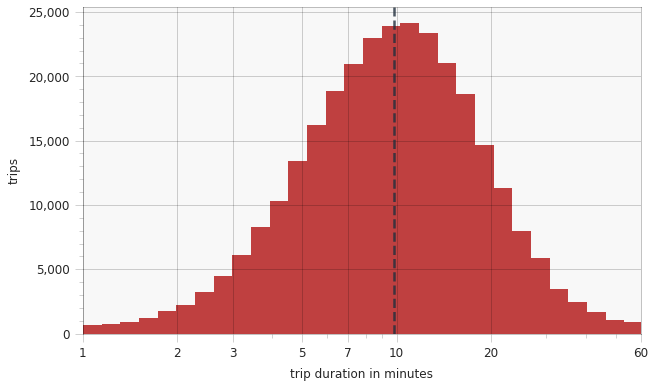

In [88]:
fix, ax = plt.subplots(figsize=(10,6))

plot_4_1(ax, df, text_font = 17, tick_font = 12, label_font = 14, title_font = 15,legend_font = 12)

plt.show()

In [89]:
df[['duration_min','duration_sec']].median()

duration_min      9.8
duration_sec    588.0
dtype: float64

In [90]:
np.percentile(df['duration_min'], [5,25,50,75,95, 99])

array([ 2.96666667,  6.15      ,  9.8       , 15.2       , 29.06666667,
       63.77166667])

#### 4.2 time vs. user

In [91]:
def plot_4_2(ax, df, text_font = 17, tick_font = 12, label_font = 14, title_font = 15,legend_font = 12):
    color_palette = {'Subscriber': set_colors['red'], 'Customer': set_colors['mid_grey']}
    g = sns.boxplot(ax=ax, data = df, x = 'user_type', y = 'duration_min', palette=color_palette, sym="", whis=[5,95])
    ax.axhline(df['duration_min'].median(), c='#212F3D', lw=2.5, linestyle='--', alpha = 0.7)


    # format y-axis to thousand-format
    g.set_yticklabels(['{:,.0f}'.format(v) for v in g.get_yticks()], size = tick_font)
    g.set_xticklabels(g.get_xticklabels(), size = tick_font)
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.tick_params(axis='y',which = 'minor', direction = 'in')
    ax.tick_params(axis='x',which = 'minor', direction = 'out', length=0)

    # label and title
    ax.set_xlabel(' ', fontsize = label_font)
    ax.set_ylabel('trip duration (min)', fontsize = label_font)
    ax.set_title('user-type', fontsize = title_font)


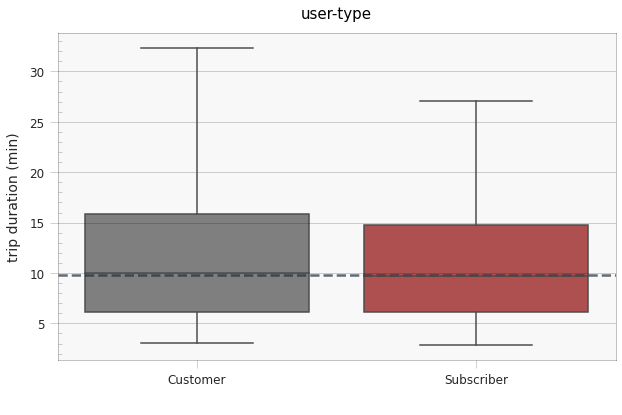

In [92]:
fix, ax = plt.subplots(figsize=(10,6))

plot_4_2(ax, df, text_font = 17, tick_font = 12, label_font = 14, title_font = 15,legend_font = 12)

plt.show()

In [93]:
df.groupby('user_type')[['duration_min','duration_sec']].median()

,duration_min,duration_sec
user_type,,
Customer,9.983333,599
Subscriber,9.683333,581


#### 4.3 time vs. rentall_access_method

In [94]:
def plot_4_3(ax, df, text_font = 17, tick_font = 12, label_font = 14, title_font = 15,legend_font = 12):
    color_palette = {'app': set_colors['red'], 'undefined': set_colors['mid_grey'], 'clipper': set_colors['light_grey']}
    g = sns.boxplot(ax=ax, data = df, x = 'rental_access_method', y = 'duration_min', palette=color_palette, sym="", whis=[5,95])
    ax.axhline(df['duration_min'].median(), c='#212F3D', lw=2.5, linestyle='--', alpha = 0.7)

    # format y-axis to thousand-format
    g.set_yticklabels(['{:,.0f}'.format(v) for v in g.get_yticks()], size = tick_font)
    g.set_xticklabels(g.get_xticklabels(), size = tick_font)
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.tick_params(axis='y',which = 'minor', direction = 'in')
    ax.tick_params(axis='x',which = 'minor', direction = 'out', length=0)

    # label and title
    ax.set_xlabel(' ', fontsize = label_font)
    ax.set_ylabel('trip duration (min)', fontsize = label_font)
    ax.set_title('rental access method', fontsize = title_font)


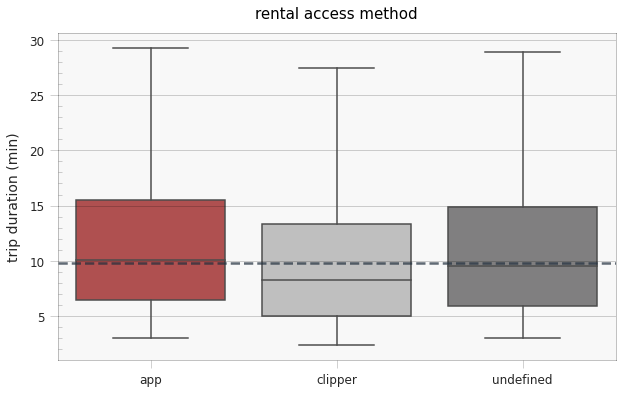

In [95]:
fix, ax = plt.subplots(figsize=(10,6))

plot_4_3(ax, df, text_font = 17, tick_font = 12, label_font = 14, title_font = 15,legend_font = 12)

plt.show()

In [96]:
df.groupby('rental_access_method')[['duration_min','duration_sec']].median()

,duration_min,duration_sec
rental_access_method,,
app,10.100000,606
clipper,8.283333,497
undefined,9.516667,571


#### 4.4 location

In [97]:
def plot_4_4(ax, df, text_font = 17, tick_font = 12, label_font = 14, title_font = 15,legend_font = 12):
    color_palette = {'SF': set_colors['red'], 'BK': set_colors['mid_grey'], 'SJ': set_colors['light_grey']}
    g = sns.boxplot(ax=ax, data = df, x = 'loc', y = 'duration_min', palette=color_palette, sym="", whis=[5,95])
    ax.axhline(df['duration_min'].median(), c='#212F3D', lw=2.5, linestyle='--', alpha = 0.7)


    # format y-axis to thousand-format
    g.set_yticklabels(['{:,.0f}'.format(v) for v in g.get_yticks()], size = tick_font)
    g.set_xticklabels(g.get_xticklabels(), size = tick_font)
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.tick_params(axis='y',which = 'minor', direction = 'in')
    ax.tick_params(axis='x',which = 'minor', direction = 'out', length=0)

    # label and title
    ax.set_xlabel(' ', fontsize = label_font)
    ax.set_ylabel('trip duration (min)', fontsize = label_font)
    ax.set_title('location', fontsize = title_font)

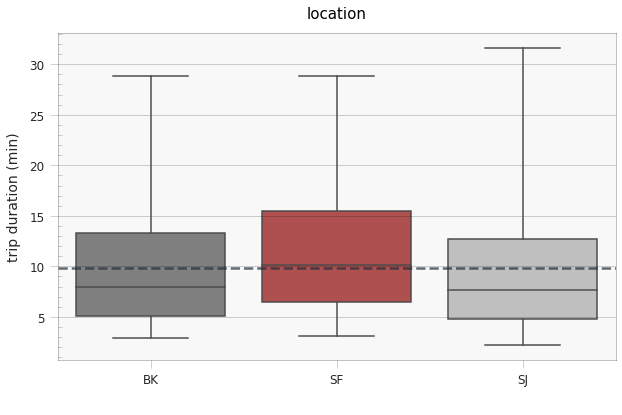

In [98]:
fix, ax = plt.subplots(figsize=(10,6))

plot_4_4(ax, df, text_font = 17, tick_font = 12, label_font = 14, title_font = 15,legend_font = 12)

plt.show()

In [99]:
df.groupby('loc')[['duration_min','duration_sec']].median()

,duration_min,duration_sec
loc,,
BK,7.983333,479
SF,10.183333,611
SJ,7.683333,461


#### 4.5 combined
***

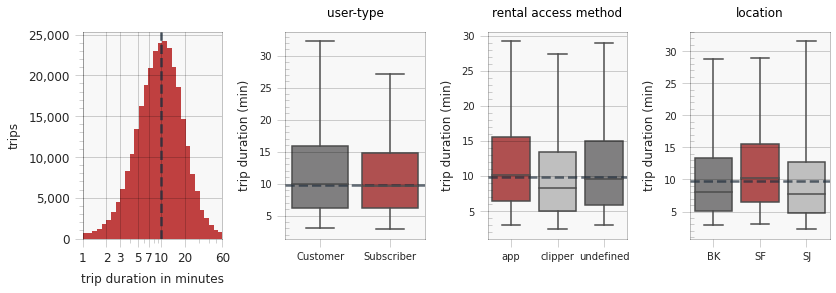

In [100]:
fig, ax = plt.subplots(1,4)
plt.subplots_adjust(bottom=0.15, wspace=0.45, hspace=0.25) # ensure y-label plot two isn't overlapped

plot_4_1(ax[0], df, text_font = 17, tick_font = 10, label_font = 12, title_font = 12,legend_font = 12)

plot_4_2(ax[1], df, text_font = 17, tick_font = 10, label_font = 12, title_font = 12,legend_font = 12)

plot_4_3(ax[2], df, text_font = 17, tick_font = 10, label_font = 12, title_font = 12,legend_font = 12)

plot_4_4(ax[3], df, text_font = 17, tick_font = 10, label_font = 12, title_font = 12,legend_font = 12)

# output
fig.set_size_inches([cm2inch(34),cm2inch(10)])
fig.savefig(path+'slide4.svg', dpi=300)

## Slide 5: distance & time
***

#### 5.1 time

In [105]:
def plot_5_1(ax, df, text_font = 17, tick_font = 12, label_font = 14, title_font = 15):
    # add shading based on the week
    x_offset = 0.5 # barplot; start is 0.5 before 'number'
    patch_alpha = 0.2
    ax.axvspan(7-x_offset, 10 - x_offset, color = 'grey', alpha = patch_alpha)
    ax.axvspan(16-x_offset, 19 - x_offset, color = 'grey', alpha = patch_alpha)

    
    
    # main plot
    g = sns.pointplot(ax=ax, data=df, x = 'hour', y = 'duration_min', hue = 'day_type',
                      palette = {'weekday': set_colors['red'], 'weekend': set_colors['mid_grey']}, dodge=0.3, estimator = np.median)
    ax.axhline(df['duration_min'].median(), c='#212F3D', lw=2.5, linestyle='--', alpha = 0.7)


    # format y-axis to thousand-format
    ax.set_yticks(np.arange(0,14,2), ['{:,.0f}'.format(v) for v in np.arange(0, 14, 2)])
    g.set_xticklabels([v+1 if v%2==0 else "" for v in g.get_xticks()]) # only odd
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.tick_params(axis='y',which = 'minor', direction = 'in')
    ax.tick_params(axis='both',which = 'major', labelsize = tick_font)
    ax.set_ylim(0,13)
    
    # label and title
    #ax.set_xlabel('hour', fontsize = label_font)
    ax.set_xlabel('hour')
    ax.set_ylabel('trip duration (min)', fontsize = label_font)
    #ax.set_title('duration Bay Wheels trips per hour', fontsize = title_font)
    ax.set_title(' ')
    #ax.legend().set_visible(False)

/Users/gijsvanpamelen/projects/bay_wheels_trips/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


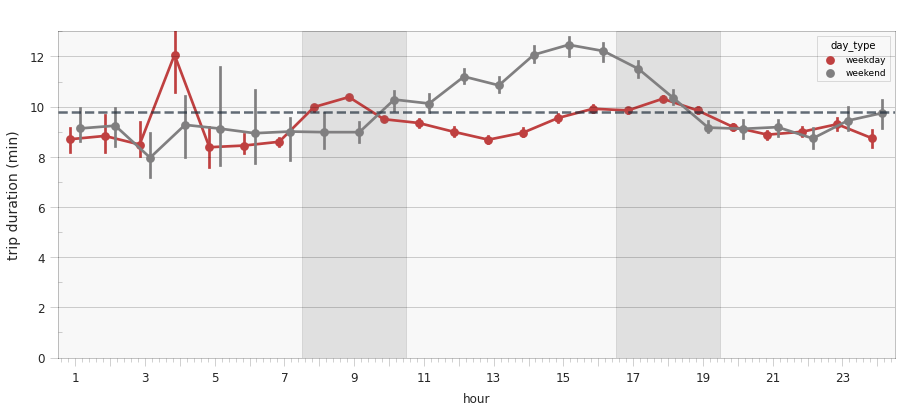

In [106]:
fig, ax = plt.subplots(figsize = (15,6))

plot_5_1(ax, df, text_font = 17, tick_font = 12, label_font = 14, title_font = 15)

plt.show()

#### 5.2 distance

In [107]:
def plot_5_2(ax, df, text_font = 17, tick_font = 12, label_font = 14, title_font = 15, legend_font = 12):
    # add shading based on the week
    x_offset = 0.5 # barplot; start is 0.5 before 'number'
    patch_alpha = 0.2
    ax.axvspan(7-x_offset, 10 - x_offset, color = 'grey', alpha = patch_alpha)
    ax.axvspan(16-x_offset, 19 - x_offset, color = 'grey', alpha = patch_alpha)
    
    
    # main plot
    g = sns.pointplot(ax=ax, data=df, x = 'hour', y = 'distance_km', hue = 'day_type',
                      palette = {'weekday': set_colors['red'], 'weekend': set_colors['mid_grey']}, dodge=0.3, estimator = np.median)
    ax.axhline(df['distance_km'].median(), c='#212F3D', lw=2.5, linestyle='--', alpha = 0.7)

    # format y-axis to thousand-format
    ax.set_yticks(np.arange(0,3,0.5), ['{:,.1f}'.format(v) for v in np.arange(0,3,0.5)])
    #g.set_yticklabels(['{:,.0f}'.format(v) for v in g.get_yticks()], size = tick_font)
    g.set_xticklabels([v+1 if v%2==0 else "" for v in g.get_xticks()], size = tick_font) # only odd
    ax.yaxis.set_minor_locator(MultipleLocator(500))
    ax.tick_params(axis='y',which = 'minor', direction = 'in')
    ax.tick_params(axis='both',which = 'major', labelsize = tick_font)
    ax.set_ylim(0,2.5)
    
    # label and title
    ax.set_xlabel('hour', fontsize = label_font)
    ax.set_ylabel('trip distance (km)', fontsize = label_font)
    #ax.set_title('distance Bay Wheels trips per hour', fontsize = title_font)
    ax.set_title(' ')
    #ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
    #            mode="expand", borderaxespad=0, ncol=3, fontsize = legend_font)

/Users/gijsvanpamelen/projects/bay_wheels_trips/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


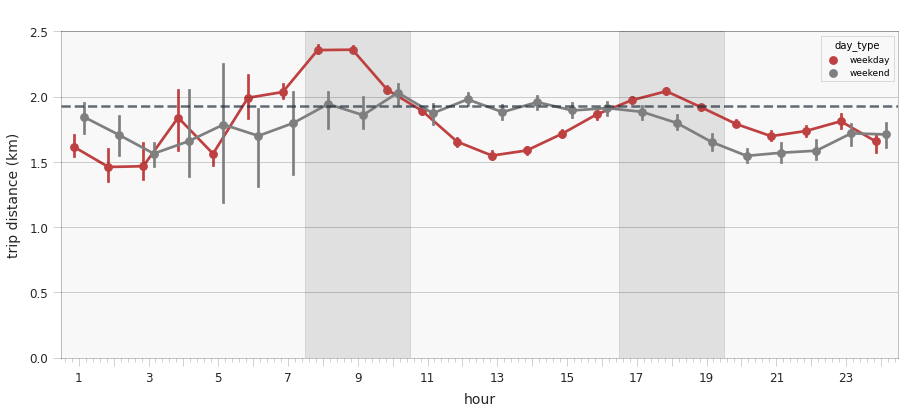

In [108]:
fig, ax = plt.subplots(figsize = (15,6))

plot_5_2(ax, df, text_font = 17, tick_font = 12, label_font = 14, title_font = 15)

plt.show()

In [109]:
df.distance_km.median()

1.9279095185716035

#### 5.3 distance vs. km (regression)

In [110]:
np.corrcoef(np.log10(reg_subset['duration_min']), np.log10(reg_subset['distance_km']))[0,1]

0.7742683127503135

In [112]:
# correlation
log_coeff = np.polyfit(np.log10(reg_subset['duration_min']), np.log10(reg_subset['distance_km']),1)
log_coeff

array([ 0.83810197, -0.54359709])

In [113]:
# line-setup
x_log_fit = np.arange(0.1,30,0.1)
y_log_fit = 10**(log_coeff[0]*np.log10(x_log_fit) + log_coeff[1])

In [114]:
def plot_5_3(ax, df, x_log_fit, y_log_fit, text_font = 17, tick_font = 12, label_font = 14, title_font = 15):
    # plot data
    ax.scatter(data = df.sample(100000), x = 'duration_min', y = 'distance_km', s = 0.4, alpha = 0.1)
    ax.plot(x_log_fit, y_log_fit, lw = 2, c = 'k') #, label = 'log-fit')

    # update tick size
    ax.set_xlim(0,30)
    ax.set_ylim(-0.1,10)
    ax.set_xticklabels(['{:,.0f}'.format(v) for v in ax.get_xticks()], size = tick_font)
    #ax.set_yticklabels(['{:,.0f}'.format(v) for v in ax.get_yticks()], size = tick_font)
    ax.set_yticks(np.arange(0,12,2), ['{:,.0f}'.format(v) for v in np.arange(0,12,2)])
    ax.tick_params(axis='both',which = 'major', labelsize = tick_font)


    # labels
    ax.set_xlabel('trip duration (min)', size = label_font)
    ax.set_ylabel('trip distance (km)', size = label_font)
    #ax.set_title('duration vs. distance'.format(corr), size = title_font)
    ax.set_title(' ')

/Users/gijsvanpamelen/projects/bay_wheels_trips/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


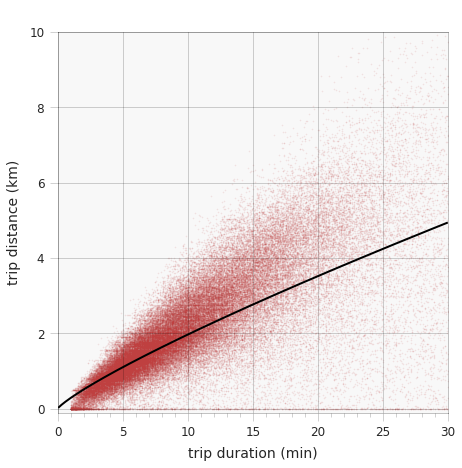

In [115]:
fig, ax = plt.subplots(figsize = (7,7))

plot_5_3(ax, df, x_log_fit, y_log_fit, text_font = 17, tick_font = 12, label_font = 14, title_font = 15)

plt.show()

#### 5.4 combined in 2-1 layout

/Users/gijsvanpamelen/projects/bay_wheels_trips/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/Users/gijsvanpamelen/projects/bay_wheels_trips/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app
/Users/gijsvanpamelen/projects/bay_wheels_trips/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


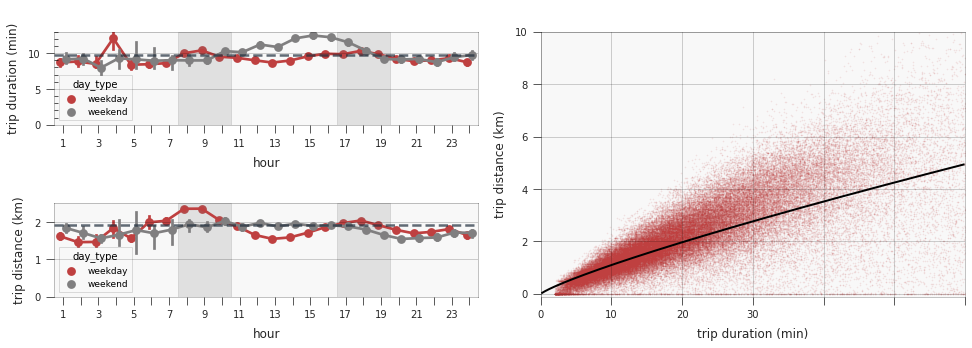

In [116]:
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax_1 = fig.add_subplot(spec[0, 0])
plot_5_1(ax_1, df, text_font = 17, tick_font = 10, label_font = 12, title_font = 13)

ax_2 = fig.add_subplot(spec[1, 0])
plot_5_2(ax_2, df, text_font = 17, tick_font = 10, label_font = 12, title_font = 13)

ax_3 = fig.add_subplot(spec[:, 1])
plot_5_3(ax_3, df, x_log_fit, y_log_fit, tick_font = 10, label_font = 12, title_font = 13)

#plt.show()
# output
fig.set_size_inches([cm2inch(34),cm2inch(12)])
fig.savefig(path+'slide5_2.svg', dpi=300)

#### 5.5 combined in vertical stack

/Users/gijsvanpamelen/projects/bay_wheels_trips/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/Users/gijsvanpamelen/projects/bay_wheels_trips/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app
/Users/gijsvanpamelen/projects/bay_wheels_trips/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


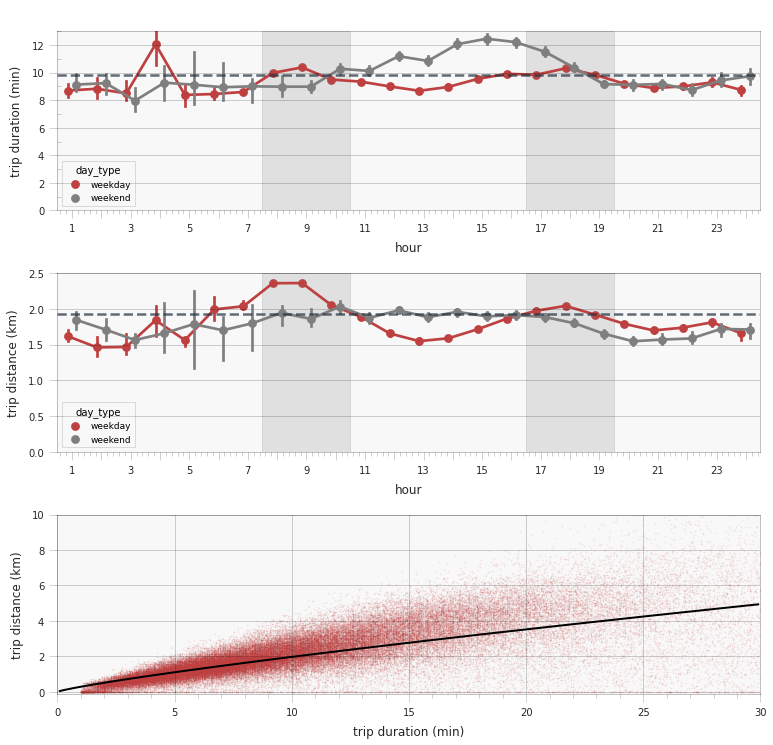

In [118]:
fig, ax = plt.subplots(3, 1)
plt.subplots_adjust(bottom=0.15, wspace=0.25, hspace=0.35) # ensure y-label plot two isn't overlapped

plot_5_1(ax[0], df, text_font = 17, tick_font = 10, label_font = 12, title_font = 13)

plot_5_2(ax[1], df, text_font = 17, tick_font = 10, label_font = 12, title_font = 13)

plot_5_3(ax[2], df, x_log_fit, y_log_fit, tick_font = 10, label_font = 12, title_font = 13)


# output
fig.set_size_inches([cm2inch(32),cm2inch(32)])
fig.savefig(path + 'slide5_1.svg', dpi=300)

## Appendix: duration over 45 mins
***

In [119]:
long = df[df['duration_min']>45]
long.shape

(5354, 27)

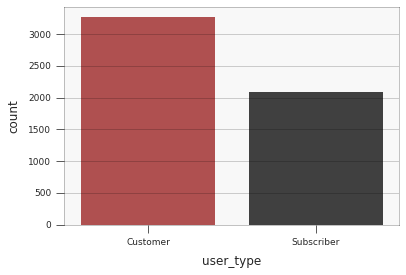

In [120]:
sns.countplot(data = long, x = 'user_type')

In [121]:
long.groupby(['user_type']).size()/len(long)

user_type
Customer      0.609264
Subscriber    0.390736
dtype: float64